In [1]:
import torch
from torch import no_grad
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    CrossEntropyLoss
)
import torch.nn.functional as F

from torchvision import datasets, transforms
import torchmetrics

import numpy as np
import matplotlib.pyplot as plt


In [2]:
torch.manual_seed(42)
batch_size = 32

# Train DataLoader
data_root = "./us8k/"

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)), 
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
train_dataset = custom_dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Number of training samples:", len(train_dataset))

# Test DataLoader
data_root = "./us8k_test/" 

data_transform = transforms.Compose([
    #transforms.Resize((400, 1000)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

custom_dataset = datasets.ImageFolder(root=data_root, transform=data_transform)
test_dataset = custom_dataset
test_loader = DataLoader(test_dataset, shuffle=False)

print("Number of test samples:", len(test_dataset))

Number of training samples: 1862
Number of test samples: 138


In [5]:
class CNN(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(3, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.conv3 = Conv2d(16, 64, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(35328, 64)
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))      
        x= self.fc3(x)
        return torch.cat((x, 1 - x), -1)

In [13]:
model = CNN() # Model
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Optimizer 
loss_func = CrossEntropyLoss() # Loss Functions
epochs = 25  # Set number of epochs
loss_list = []  # Store loss history

model.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [4%]	Loss: 0.7395
Training [8%]	Loss: 0.6364
Training [12%]	Loss: 0.5793
Training [16%]	Loss: 0.5420
Training [20%]	Loss: 0.5002
Training [24%]	Loss: 0.4626
Training [28%]	Loss: 0.4221
Training [32%]	Loss: 0.3667
Training [36%]	Loss: 0.3126
Training [40%]	Loss: 0.2763
Training [44%]	Loss: 0.2725
Training [48%]	Loss: 0.2325
Training [52%]	Loss: 0.2252
Training [56%]	Loss: 0.2180
Training [60%]	Loss: 0.2186
Training [64%]	Loss: 0.2028
Training [68%]	Loss: 0.1904
Training [72%]	Loss: 0.1787
Training [76%]	Loss: 0.1766
Training [80%]	Loss: 0.1500
Training [84%]	Loss: 0.1687
Training [88%]	Loss: 0.1467
Training [92%]	Loss: 0.1517
Training [96%]	Loss: 0.1373
Training [100%]	Loss: 0.1255


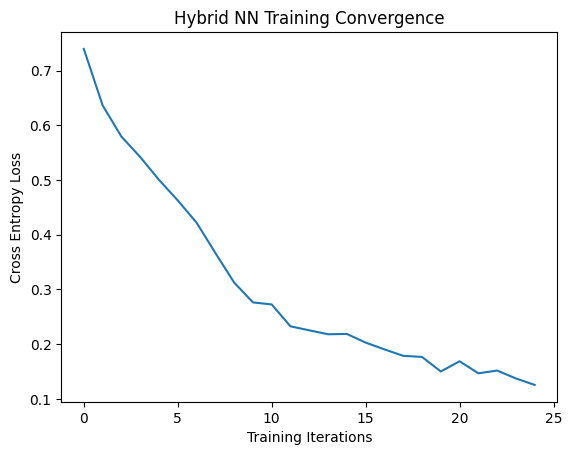

In [14]:
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [15]:
PATH = 'models/us8k_cnn_classical.pt'
torch.save(model.state_dict(), PATH)

In [16]:
import torch
PATH = 'models/us8k_cnn_classical.pt'
model = CNN()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
from torchmetrics.classification import Accuracy, ConfusionMatrix, BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryHingeLoss
model.eval()

CNN(
  (conv1): Conv2d(3, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=35328, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [18]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in test_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.9202898740768433
Cross-Entropy Loss: 0.0018122454639524221
Confusion Matrix:
[[68, 1], [10, 59]]
F1 Score: 0.9147287011146545
Binary Precision: 0.9833333492279053
Binary Recall: 0.8550724387168884


In [20]:
y_true = []
y_pred_probs = []

with torch.no_grad():

    for images, labels in train_loader:
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1)
        y_true.extend(labels.tolist())
        y_pred_probs.extend(probabilities.tolist())

y_pred_probs = torch.tensor(y_pred_probs)
y_pred = torch.argmax(y_pred_probs, dim=1)

# Calculate accuracy
accuracy = Accuracy(task="binary")(y_pred, torch.tensor(y_true))
print("Accuracy:", accuracy.item())

# Calculate cross-entropy loss
loss_func = CrossEntropyLoss()
CELoss = loss_func(outputs, labels)
print("Cross-Entropy Loss:", CELoss.item())

# Calculate confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_result = confmat(y_pred, torch.tensor(y_true))
print("Confusion Matrix:")
print(confmat_result.tolist())

# Calculate F1 Score
f1 = BinaryF1Score()
f1_result = f1(y_pred, torch.tensor(y_true))
print("F1 Score:", f1_result.item())

# Calculate Binary Precision
precision = BinaryPrecision()
precision_result = precision(y_pred, torch.tensor(y_true))
print("Binary Precision:", precision_result.item())

# Calculate Binary Recall
recall = BinaryRecall()
recall_result = recall(y_pred, torch.tensor(y_true))
print("Binary Recall:", recall_result.item())

Accuracy: 0.9747583270072937
Cross-Entropy Loss: 0.296747088432312
Confusion Matrix:
[[910, 21], [26, 905]]
F1 Score: 0.9746903777122498
Binary Precision: 0.9773218035697937
Binary Recall: 0.9720730185508728
